In [2]:
import torch
import torch.nn as nn 
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import os 
import random
import numpy as np 

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# 图像的Normalize

In [3]:
data_trans=transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomCrop(32,padding=3),
    transforms.ToTensor(),
    transforms.Normalize((0.49139968, 0.48215827, 0.44653124), (0.24703233, 0.24348505, 0.26158768))#参数mean和std来自于训练集，但是transform本身会在训练和评测的时候都会使用
])

In [4]:
data_trans_227=transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomCrop(32,padding=3),
    transforms.Resize(227),
    transforms.ToTensor(),
    transforms.Normalize((0.49139968, 0.48215827, 0.44653124), (0.24703233, 0.24348505, 0.26158768))#参数mean和std来自于训练集，但是transform本身会在训练和评测的时候都会使用
])

In [5]:
data_test=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.49139968, 0.48215827, 0.44653124), (0.24703233, 0.24348505, 0.26158768))
])

In [6]:
data_test_227=transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(227),
    transforms.Normalize((0.49139968, 0.48215827, 0.44653124), (0.24703233, 0.24348505, 0.26158768))
])

In [7]:
train_data=datasets.CIFAR10('data',train=True,download=True,transform=data_trans)
test_data=datasets.CIFAR10('data',train=False,download=True,transform=data_trans)

Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


In [9]:
n_train=int(len(train_data)*0.9)
n_validation=len(train_data)-n_train

In [10]:
train_data,valid_data=torch.utils.data.random_split(train_data,[n_train,n_validation])

In [11]:
print(len(train_data),len(valid_data),len(test_data))

45000 5000 10000


In [12]:
batch_size=64

In [13]:
train_iterator=torch.utils.data.DataLoader(train_data,shuffle=True,batch_size=batch_size)
valid_iterator=torch.utils.data.DataLoader(valid_data,batch_size=batch_size)
test_iterator=torch.utils.data.DataLoader(test_data,batch_size=batch_size)

# 定义DenseNet121模型

In [19]:
import math
class Bottleneck(nn.Module):
    def __init__(self,in_planes,growth_rate):
        super(Bottleneck,self).__init__()
        self.bn1=nn.BatchNorm2d(in_planes)
        self.conv1=nn.Conv2d(in_planes,4*growth_rate,kernel_size=1,bias=False)
        self.bn2=nn.BatchNorm2d(4*growth_rate)
        self.conv2=nn.Conv2d(4*growth_rate,growth_rate,kernel_size=3,padding=1,bias=False)
        
    def forward(self,x):
        out=self.conv1(F.relu(self.bn1(x)))#pre-activation
        out=self.conv2(F.relu(self.bn2(out)))
        out=torch.cat([out,x],1)
        return out
class Transition(nn.Module):
    def __init__(self,in_planes,out_planes):
        super(Transition,self).__init__()
        self.bn=nn.BatchNorm2d(in_planes)
        self.conv=nn.Conv2d(in_planes,out_planes,kernel_size=1,bias=False)
    def forward(self,x):
        out=self.conv(F.relu(self.bn(x)))
        out=F.avg_pool2d(out,2)
        return out
class DenseNet(nn.Module):
    def __init__(self,block,nblocks,growth_rate=12,reduction=0.5,num_classes=10):
        super(DenseNet,self).__init__()
        self.growth_rate=growth_rate
        num_planes=2*growth_rate #32
        #最初的感知层
        self.conv1=nn.Conv2d(3,num_planes,kernel_size=3,padding=1,bias=False)
        #第一个DenseBlock
        self.dense1=self._make_dense_layers(block,num_planes,nblocks[0])
        num_planes+=nblocks[0]*growth_rate
        out_planes=int(math.floor(num_planes*reduction))
        self.trans1=Transition(num_planes,out_planes)
        num_planes=out_planes
        #第二个DenseBlock
        self.dense2 = self._make_dense_layers(block, num_planes, nblocks[1])
        num_planes += nblocks[1]*growth_rate#计算如果不压缩的话的输出
        out_planes = int(math.floor(num_planes*reduction))
        self.trans2 = Transition(num_planes, out_planes)
        num_planes = out_planes
        #第三个DenseBlock
        self.dense3 = self._make_dense_layers(block, num_planes, nblocks[2])
        num_planes += nblocks[2]*growth_rate
        out_planes = int(math.floor(num_planes*reduction))
        self.trans3 = Transition(num_planes, out_planes)
        num_planes = out_planes
        #第四个DenseBlock
        self.dense4 = self._make_dense_layers(block, num_planes, nblocks[3])
        num_planes += nblocks[3]*growth_rate
        #分类层
        self.bn=nn.BatchNorm2d(num_planes)
        self.linear=nn.Linear(num_planes,num_classes)
    
    
    def _make_dense_layers(self,block,in_planes,nblock):
        #block:bottleneck
        #nblock代表构建denseblock中有多少bottleneck层
        layers=[]
        for i in range(nblock):
            layers.append(block(in_planes,self.growth_rate))
            in_planes+=self.growth_rate
        return nn.Sequential(*layers)
    
    def forward(self,x):
        out=self.conv1(x)
        out=self.trans1(self.dense1(out))
        out = self.trans2(self.dense2(out))
        out = self.trans3(self.dense3(out))
        out = self.dense4(out)
        out=F.avg_pool2d(F.relu(self.bn(out)),4)
        out=out.view(out.size(0),-1)
        out=self.linear(out)
        return out

def DenseNet121():
    return DenseNet(Bottleneck,[6,12,24,16],growth_rate=32)

# 载入模型并训练

In [14]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [16]:
model_dir='/content/drive/My Drive/Colab Notebooks/models'
if not os.path.isdir(model_dir):
    os.makedirs(model_dir)

In [17]:
device

device(type='cuda')

In [20]:
model=DenseNet121().to(device)
model_path=os.path.join(model_dir,'densenet_c10.pt')

In [21]:
optimizer=optim.Adam(model.parameters())
criterion=nn.CrossEntropyLoss()

## 定义计算精确度方法

In [22]:
def accu(fx,y):
    pred=fx.max(1,keepdim=True)[1]
    correct=pred.eq(y.view_as(pred)).sum()#得到该batch的准确度
    acc=correct.float()/pred.shape[0]
    return acc

## 定义训练方法

In [23]:
def train(model,device,iterator,optimizer,criterion):
    epoch_loss=0#积累变量
    epoch_acc=0#积累变量
    model.train()#该函数表示PHASE=Train
    
    for (x,y) in iterator:#拿去每一个minibatch
        x=x.to(device)
        y=y.to(device)
        optimizer.zero_grad()
        fx=model(x)#进行forward
        loss=criterion(fx,y)#计算Loss,train_loss
        type(loss)
        acc=accu(fx,y)#计算精确度，train_accu
        loss.backward()#进行BP
        optimizer.step()#统一更新模型
        epoch_loss+=loss.item()
        epoch_acc+=acc.item()
        
    return epoch_loss/len(iterator),epoch_acc/len(iterator)

## 定义评测方法

In [24]:
def evaluate(model,device,iterator,criterion):
    epoch_loss=0
    epoch_acc=0
    model.eval()
    with torch.no_grad():
        for (x,y) in iterator:
            x=x.to(device)
            y=y.to(device)
            fx=model(x)
            loss=criterion(fx,y)
            acc=accu(fx,y)
            epoch_loss+=loss.item()
            epoch_acc+=acc.item()
    return epoch_loss/len(iterator),epoch_acc/len(iterator)

In [ ]:
epochs=30
best_valid_loss=float('inf')

In [ ]:
for epoch in range(epochs):
    train_loss,train_acc=train(model,device,train_iterator,optimizer,criterion)
    valid_loss,valid_acc=evaluate(model,device,valid_iterator,criterion)
    if valid_loss<best_valid_loss:#如果是最好的模型就保存到文件夹
        best_valid_loss=valid_loss
        torch.save(model.state_dict(),model_path)
    print('Epoch:{0}|Train Loss:{1}|Train Acc:{2}|Val Loss:{3}|Val Acc:{4}'.format(epoch+1,train_loss,train_acc,valid_loss,valid_acc))

Epoch:1|Train Loss:1.4460339939899065|Train Acc:0.4646218039772727|Val Loss:1.1475464837460578|Val Acc:0.5915743670886076
Epoch:2|Train Loss:0.9884696009314873|Train Acc:0.6444424715909091|Val Loss:0.9309043680565267|Val Acc:0.6693037974683544
Epoch:3|Train Loss:0.799153711477464|Train Acc:0.7173295454545454|Val Loss:0.8184317606913892|Val Acc:0.7104430379746836
Epoch:4|Train Loss:0.65658473524011|Train Acc:0.7696422230113636|Val Loss:0.5992584632167334|Val Acc:0.7939082278481012
Epoch:5|Train Loss:0.5660363551313904|Train Acc:0.8015802556818182|Val Loss:0.6318971431708034|Val Acc:0.7820411392405063
Epoch:6|Train Loss:0.5056105740156702|Train Acc:0.8237970525568182|Val Loss:0.5096503077428552|Val Acc:0.8194224683544303
Epoch:7|Train Loss:0.4540885598398745|Train Acc:0.8418412642045454|Val Loss:0.4678512355194816|Val Acc:0.8358386075949367
Epoch:8|Train Loss:0.41199494151144544|Train Acc:0.8575550426136364|Val Loss:0.44755783413029926|Val Acc:0.8496835443037974
Epoch:9|Train Loss:0.3784

In [25]:
model.load_state_dict(torch.load(model_path))
test_loss, test_acc = evaluate(model, device, test_iterator, criterion)
print('| Test Loss: {0} | Test Acc: {1} |'.format(test_loss,test_acc))

| Test Loss: 0.3291512867257853 | Test Acc: 0.8986863057324841 |


# 模型的评测

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc,precision_recall_curve,average_precision_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp

In [27]:
prediction=[]
groundtruth=[]

In [28]:
def evaluate2(model,device,iterator,criterion):
    epoch_loss=0
    epoch_acc=0
    model.eval()
    with torch.no_grad():
        for (x,y) in iterator:
            x=x.to(device)
            y=y.to(device)
            fx=model(x)
            loss=criterion(fx,y)
            prediction.append(fx)
            groundtruth.append(y)
            acc=accu(fx,y)
            epoch_loss+=loss.item()
            epoch_acc+=acc.item()
    return epoch_loss/len(iterator),epoch_acc/len(iterator)

In [29]:
model.load_state_dict(torch.load(model_path))
test_loss, test_acc = evaluate2(model, device, test_iterator, criterion)
print('| Test Loss: {0} | Test Acc: {1} |'.format(test_loss,test_acc))

| Test Loss: 0.32754407403100827 | Test Acc: 0.900577229299363 |


In [30]:
pred=torch.cat(prediction).cpu().numpy()

In [31]:
pred.shape

(10000, 10)

In [32]:
pred[0]

array([ -8.737722 ,  -9.14482  ,  -5.143304 ,   5.3423767,  -9.795004 ,
        -2.194182 ,  -6.942836 ,  -7.611933 ,  -8.898018 , -13.93062  ],
      dtype=float32)

In [33]:
gt=torch.cat(groundtruth).cpu().numpy()

In [34]:
gt.shape

(10000,)

In [41]:
fpr=dict()
tpr=dict()
prc=dict()
rcl=dict()
roc_auc=dict()
ap=dict()

In [35]:
gt_one_hot=np.eye(10)[gt.reshape(-1)]#groundtruth的onehot化

In [36]:
gt_one_hot[0]

array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0.])

In [37]:
pred_soft=F.softmax(torch.cat(prediction).cpu()).cpu().numpy()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  """Entry point for launching an IPython kernel.


In [38]:
pred_soft[0]

array([7.6708409e-07, 5.1055514e-07, 2.7917667e-05, 9.9942988e-01,
       2.6648419e-07, 5.3292548e-04, 4.6169198e-06, 2.3646519e-06,
       6.5347285e-07, 4.2618300e-09], dtype=float32)

In [42]:
for i in range(10):
    fpr[i],tpr[i],_=roc_curve(gt_one_hot[:,i],pred_soft[:,i])
    roc_auc[i]=auc(fpr[i],tpr[i])
    prc[i],rcl[i],_=precision_recall_curve(gt_one_hot[:,i],pred_soft[:,i])
    ap[i]=average_precision_score(gt_one_hot[:,i],pred_soft[:,i])

In [44]:
tpr[0].shape

(378,)

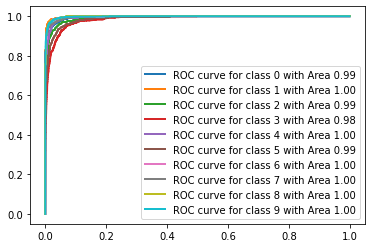

In [43]:
for i in range(10):
    plt.plot(fpr[i],tpr[i],lw=2,label='ROC curve for class %d with Area %0.2f'%(i,roc_auc[i]))
plt.legend()

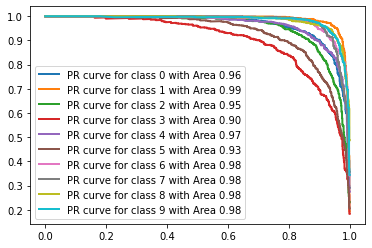

In [45]:
for i in range(10):
    plt.plot(rcl[i],prc[i],lw=2,label='PR curve for class %d with Area %0.2f'%(i,ap[i]))
plt.legend()

## Micro的实现

Micro认为所有的分类1......k都是同一类，因此将所有的gt和预测的结果合并成为1个数组来进行评判

In [46]:
gt_one_hot.ravel().shape

(100000,)

In [47]:
pred_soft.ravel().shape

(100000,)

In [48]:
fpr['micro'],tpr['micro'],_=roc_curve(gt_one_hot.ravel(),pred_soft.ravel())

In [49]:
prc['micro'],rcl['micro'],_=precision_recall_curve(gt_one_hot.ravel(),pred_soft.ravel())

In [50]:
ap['micro']=average_precision_score(gt_one_hot.ravel(),pred_soft.ravel(),average='micro')

In [51]:
roc_auc['micro']=auc(fpr['micro'],tpr['micro'])

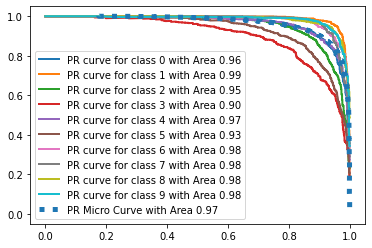

In [52]:
for i in range(10):
    plt.plot(rcl[i],prc[i],lw=2,label='PR curve for class %d with Area %0.2f'%(i,ap[i]))
plt.plot(prc['micro'],rcl['micro'],lw=5,linestyle=":",label='PR Micro Curve with Area %0.2f'%(ap['micro']))
    
plt.legend()


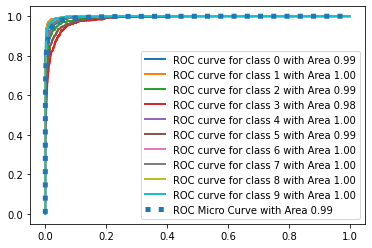

In [53]:
for i in range(10):
    plt.plot(fpr[i],tpr[i],lw=2,label='ROC curve for class %d with Area %0.2f'%(i,roc_auc[i]))
plt.plot(fpr['micro'],tpr['micro'],lw=5,linestyle=":",label='ROC Micro Curve with Area %0.2f'%(roc_auc['micro']))
 
plt.legend()

## Macro的计算

In [54]:
all_fpr=np.unique(np.concatenate([fpr[i] for i in range(10)]))#获得所有的fpr插值点

In [55]:
np.concatenate([fpr[i] for i in range(10)]).shape

(3509,)

In [56]:
all_prc=np.unique(np.concatenate([prc[i] for i in range(10)]))#获得所有的prc的插值点

In [57]:
mean_tpr=np.zeros_like(all_fpr)
mean_rcl=np.zeros_like(all_prc)

In [58]:
mean_tpr.shape

(609,)

In [59]:
for i in range(10):
    mean_tpr+=interp(all_fpr,fpr[i],tpr[i])
    mean_rcl+=interp(all_prc,prc[i],rcl[i])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  This is separate from the ipykernel package so we can avoid doing imports until


In [60]:
mean_tpr/=10

In [61]:
mean_rcl/=10

In [62]:
fpr['macro']=all_fpr
prc['macro']=all_prc
tpr['macro']=mean_tpr
rcl['macro']=mean_rcl
roc_auc['macro']=auc(fpr['macro'],tpr['macro'])
ap['macro']=average_precision_score(gt_one_hot.ravel(),pred_soft.ravel(),average='macro')

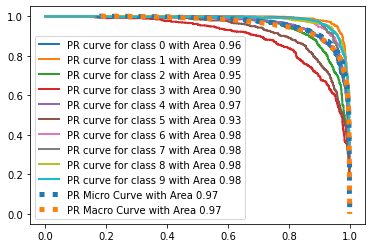

In [63]:
for i in range(10):
    plt.plot(rcl[i],prc[i],lw=2,label='PR curve for class %d with Area %0.2f'%(i,ap[i]))
plt.plot(prc['micro'],rcl['micro'],lw=5,linestyle=":",label='PR Micro Curve with Area %0.2f'%(ap['micro']))
plt.plot(prc['macro'],rcl['macro'],lw=5,linestyle=":",label='PR Macro Curve with Area %0.2f'%(ap['macro']))
    
plt.legend()

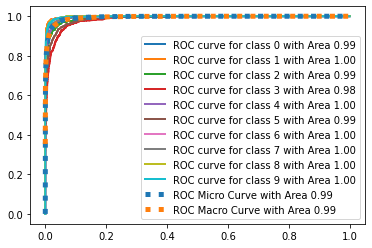

In [64]:
for i in range(10):
    plt.plot(fpr[i],tpr[i],lw=2,label='ROC curve for class %d with Area %0.2f'%(i,roc_auc[i]))
plt.plot(fpr['micro'],tpr['micro'],lw=5,linestyle=":",label='ROC Micro Curve with Area %0.2f'%(roc_auc['micro']))
plt.plot(fpr['macro'],tpr['macro'],lw=5,linestyle=":",label='ROC Macro Curve with Area %0.2f'%(roc_auc['macro']))
 
plt.legend()

In [65]:
mAP=np.asanyarray([ap[i] for i in range(10)]).mean()

In [66]:
mAP

0.9625854212228251